In [197]:
import os
project_root = os.pardir
import sys
sys.path.append(project_root)

In [198]:
import src.general as gen
from src.data import make_dataset as dat
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd
import networkx as nx
import collections as col
import numpy as np
import tqdm
import random
%matplotlib inline

In [76]:
data_dir = os.path.join(project_root, 'data', 'raw', '16-12-2016-Mega')

In [4]:
year = 1997
profits_filename = 'profits_' + str(year) + '.csv'
sizes_filename = 'sizes_' + str(year) + '.csv'
profits_filepath = os.path.join(data_dir, 'profits', profits_filename)
sizes_filepath = os.path.join(data_dir, 'sizes', sizes_filename)

In [5]:
p = pd.read_csv(profits_filepath, index_col='firm_id')
s = pd.read_csv(sizes_filepath, index_col='firm_id')
df = p.merge(s, left_index=True, right_index=True, suffixes=('_profit', '_size'))

In [6]:
a = df[df['value_size'] <10]

In [61]:
dead_sum_count.values()[:10]

[2503, 1069, 541, 374, 278, 192, 188, 149, 116, 102]

In [69]:
reload(dat)

<module 'src.data.make_dataset' from '../src/data/make_dataset.pyc'>

In [145]:
'''
Test to see whether
(i) degree, or
(ii) sum of degrees of neighbours (which I call 'nsum') 
affects the chance of a firm dying.

1. Get number of firms with each degree (or nsum)
    - Return a collections 'counter' dictionary
2. For each degree (nsum), ask what proportion died.
Be careful to recognise when numbers are too small for
proportions to be meaningful.
3. Do Monte Carlo, pciking N dead firms.
Will get a distribution for each degree.

Visualise
- Box and Whiskers plots - plot Monte Carlo distribution
- Histogram plus actual value line

Input Data
graph: LFN graph
LFN_dead_ids: ids of firms in LFN that are dead
'''

"\nTest to see whether\n(i) degree, or\n(ii) sum of degrees of neighbours (which I call 'nsum') \naffects the chance of a firm dying.\n\n1. Get number of firms with each degree (or nsum)\n    - Return a collections 'counter' dictionary\n2. For each degree (nsum), ask what proportion died.\nBe careful to recognise when numbers are too small for\nproportions to be meaningful.\n3. Do Monte Carlo, pciking N dead firms.\nWill get a distribution for each degree.\n\nVisualise\n- Box and Whiskers plots - plot Monte Carlo distribution\n- Histogram plus actual value line\n\nInput Data\ngraph: LFN graph\nLFN_dead_ids: ids of firms in LFN that are dead\n"

In [199]:
graph = dat.MakeLFN('1996-1997', print_info=False)
dead_ids = dat.GetDeadIds(death_years='all')

../src/data/../../data/raw/16-12-2016-Mega/dates_death.csv


In [200]:
def FeatureList(feature_function, graph, nodes):
    '''
    FeatureList applies feature_function to each node nodes.
    Feature_function is a function that maps (graph, node)
    to a new value - the feature we are interested in.
    Returns a list of how many nodes have each possible value
    of the feature.
    '''
    LFN_nodes = set(nodes).intersection(set(graph.nodes()))
    return [feature_function(graph, node) for node in LFN_nodes]

def SumNeighDeg(graph, node):
    '''
    Returns sum of the degrees of the neighbours of the node.
    '''
    neighs = nx.neighbors(graph, node)
    degrees = [nx.degree(graph, neigh) for neigh in neighs]
    return sum(degrees)

def AvgNeighDeg(graph, node):
    '''
    Returns average of degrees of neighbours of the node.
    '''
    return nx.average_neighbor_degree(graph, nodes=[node]).values()[0]

def PropDead(all_count, dead_count):
    '''
    Take dictionary of dead counts and compare it to dictionary of counts for
    the entire LFN by taking ratios.
    'Overall' is the overall proportion of firms that died.
    Return dictionary of proportion dead.
    '''
    prop_dead = dict()
    for key in all_count.keys():
        prop_dead[key] = dead_count[key]/float(all_count[key])
    prop_dead['Overall'] = sum(dead_count.values())/float(sum(all_count.values()))
    return prop_dead    

In [203]:
#choose the feature function we want to use
#feature_function = nx.degree
#feature_function = SumNeighDeg
feature_function = AvgNeighDeg

#choose numer of Monte Carlo runs desired
number_mc_runs = 2000

In [204]:
#get feature list and count using all nodes
all_list = FeatureList(feature_function, graph, graph.nodes())
all_count = col.Counter(all_list)
#get feature list and count using just nodes dead in LFN
dead_list = FeatureList(feature_function, graph, dead_ids)
dead_count = col.Counter(dead_list)
#number of nodes in LFN that died
ndead_in_LFN = sum(dead_count.values())
#get proportion of firms dead with each possible value of the feature
prop_dead = PropDead(all_count, dead_count)

In [119]:
#do Monte Carlo
mc_counts = []
mc_prop_deads = []
for i in tqdm.tqdm(xrange(number_mc_runs)):
    random.shuffle(all_list)
    mc_list = all_list[:ndead_in_LFN]
    mc_count = col.Counter(mc_list)
    mc_prop_dead = PropDead(all_count, mc_count)
    
    mc_counts += [mc_count]
    mc_prop_deads += [mc_prop_dead]    

100%|██████████| 1000/1000 [00:33<00:00, 30.58it/s]


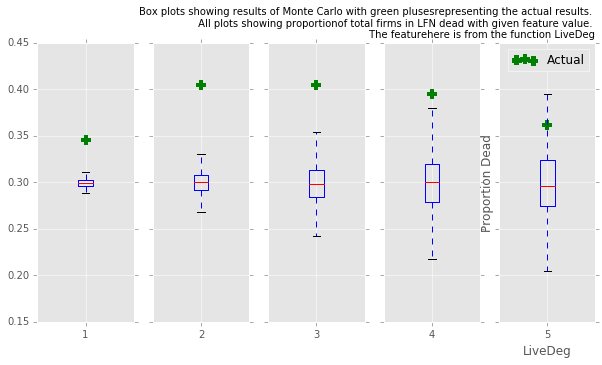

In [195]:
#compare Monte Carlo to actual results
fvs = [1, 2, 3, 4, 5] #values of the feature we want to plot
fig, axarr = plt.subplots(1, len(fvs), figsize=(10, 5), sharey=True)
ax_num = 0
for fv in fvs:
    #Get the list of proportions of firms with feature value fv
    #that are chosen to be dead in this Monte Carlo run.
    mc_prop_deads_at_fv = [x[fv] for x in mc_prop_deads]
    #Add boxplot of proportions dead in Monte Carlo runs
    axarr[ax_num].boxplot(mc_prop_deads_at_fv, showfliers = False, positions=[fv])
    #Add actual value of proportion dead
    axarr[ax_num].scatter([fv], prop_dead[fv], marker='+', color='g', linewidth=10, label='Actual')
    #Ensure that the next plot is on a new axis
    ax_num += 1
plt.legend()
feature_info = str(feature_function)[10:-16]
plt.title(
            'Box plots showing results of Monte Carlo with green pluses' \
            'representing the actual results. \n All plots showing proportion' \
            'of total firms in LFN dead with given feature value. \n The feature' \
            'here is from the function ' + feature_info,
            loc='right', fontsize=10)
plt.xlabel(feature_info)
plt.ylabel('Proportion Dead')
plt.savefig(os.path.join(
                        project_root, 'reports', 'figures',
                        'effect_of_' + feature_info + '.png'))

In [71]:
#Get Table of dead_count vs all_count
all_count_series = pd.Series(all_count, name='Number in LFN')
dead_count_series = pd.Series(dead_count, name='Number Dead')
df = pd.concat([all_count_series, dead_count_series], axis=1)
df.index.name = feature_info
df['Proportion Dead'] = df['Number Dead']/df['Number in LFN']

In [72]:
df.head(5)

,Number in LFN,Number Dead,Proportion Dead
AvgNeighDeg,,,
1.000000,9951,2954.0,0.296855
1.200000,1,NaN,NaN
1.250000,17,5.0,0.294118
1.285714,1,NaN,NaN
1.333333,71,24.0,0.338028


In [86]:
nx.neighbors(graph, 305836)

[714486]

In [109]:
all_count

Counter({0: 31661})

In [112]:
LiveDeg(graph, 305836, dead_ids)

1

In [205]:
def LiveDeg(graph, node):
    '''
    Get the live degree of the node, ie, the degree in the original LFN
    minus the number of the nodes neighbours that are already dead.
    '''
    neighs = nx.neighbors(graph, node)
    alive_neighs = 0
    for neigh in neighs:
        if graph.node[neigh]['Dead'] == True:
            alive_neighs +=1 
    return alive_neighs

def LiveDegPropDead(graph, dead_nodes):
    #live degree
    #need dictionary mapping nodes to True (for dead) or False (for alive)
    dead_dict = dict()
    for node in graph.nodes():
        dead_dict[node] = False
    for node in dead_nodes:
        dead_dict[node] = True
    nx.set_node_attributes(graph, 'Dead', dead_dict)
    #get counts of all live degrees
    all_list = [LiveDeg(graph, node) for node in graph.nodes()]
    all_count = col.Counter(all_list)
    #get counts of all dead degrees
    dead_list = [LiveDeg(graph, node) for node in dead_nodes]
    dead_count = col.Counter(dead_list)
    #get proportion dead
    prop_dead = PropDead(all_count, dead_count)
    return (prop_dead, all_count, dead_count)

In [206]:
dead_nodes = set(dead_ids).intersection(set(graph.nodes()))
prop_dead = LiveDegPropDead(graph, dead_nodes)[0]
feature_function = LiveDeg

In [207]:
#do Monte Carlo
mc_counts = []
mc_prop_deads = []
all_nodes = graph.nodes()
for i in tqdm.tqdm(xrange(number_mc_runs)):
    random.shuffle(all_nodes)
    dead_nodes = all_nodes[:ndead_in_LFN]
    mc_prop_dead = LiveDegPropDead(graph, dead_nodes)[0]
    
    mc_prop_deads += [mc_prop_dead]    

100%|██████████| 2000/2000 [08:57<00:00,  3.70it/s]


In [196]:
len(mc_prop_deads)

1000

In [150]:
neighs = nx.neighbors(graph, 524301)

In [151]:
neighs

[519013]

In [152]:
LiveDeg(graph, 524301)

KeyError: 'Dead'

In [160]:
graph.node

{393217: {'Dead': True},
 655364: {'Dead': False},
 131073: {'Dead': False},
 305836: {'Dead': False},
 524300: {'Dead': False},
 524301: {'Dead': True},
 524307: {'Dead': False},
 262166: {'Dead': True},
 895663: {'Dead': False},
 917540: {'Dead': True},
 131113: {'Dead': False},
 262194: {'Dead': True},
 786485: {'Dead': False},
 262203: {'Dead': False},
 786493: {'Dead': True},
 524352: {'Dead': False},
 131149: {'Dead': True},
 131153: {'Dead': False},
 393298: {'Dead': True},
 89: {'Dead': False},
 524378: {'Dead': False},
 262236: {'Dead': False},
 917599: {'Dead': True},
 100: {'Dead': False},
 655462: {'Dead': False},
 103: {'Dead': False},
 131177: {'Dead': False},
 106: {'Dead': False},
 131182: {'Dead': False},
 524400: {'Dead': True},
 262257: {'Dead': False},
 393335: {'Dead': True},
 393337: {'Dead': False},
 131197: {'Dead': False},
 786454: {'Dead': False},
 655499: {'Dead': True},
 786573: {'Dead': False},
 655503: {'Dead': True},
 786589: {'Dead': False},
 159: {'Dead